# Transformer emotion recognizer

Note: This notebook is designed to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer and the emotion dataset.

**You can igore the error message like `ERROR: pip's dependency resolver does not currently take into account...`.**

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_mac

Import modules and set random seeds.

In [2]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, saving, optimizers

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [3]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print(f'Vocabulary size: {VOCAB_SIZE}')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Vocabulary size: 30522


Download the emotion dataset and check the maximum text length.

In [4]:
from datasets import load_dataset
emotions = load_dataset('emotion', trust_remote_code=True)
max_textlen = max(
    [len(text.split(' '))
     for text in emotions['train']['text'] + emotions['validation']['text']])
print(f'Maximum text length: {max_textlen}')

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Maximum text length: 66


Create the training and test datasets.

In [5]:
MAX_LEN = 128

# Training set
train_set = tokenizer(emotions['train']['text'], max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])
train_mask = np.array(train_set['attention_mask'])
train_label = tf.keras.utils.to_categorical(emotions['train']['label'], 6)

# Test set
test_set = tokenizer(emotions['validation']['text'], max_length=MAX_LEN,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])
test_mask = np.array(test_set['attention_mask'])
test_label = tf.keras.utils.to_categorical(emotions['validation']['label'], 6)

emotion_labels = emotions['train'].features['label'].names
emotion_labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

Define the positional embedding layer.

In [6]:
@saving.register_keras_serializable()
class Embeddings(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim, **kwargs):
        super(Embeddings, self).__init__(**kwargs)
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=max_len,
                                        output_dim=embed_dim)
        self.dropout = layers.Dropout(rate=0.5)
        self.ln = layers.LayerNormalization(epsilon=1e-12)

    def build(self, input_shape):
        pass

    def call(self, inputs):
        seq_len = tf.shape(inputs)[-1]
        position_ids = tf.range(start=0, limit=seq_len, delta=1)
        position_embeddings = self.pos_emb(position_ids)
        token_embeddings = self.token_emb(inputs)

        # Add positional embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.ln(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

Dfiner the Transformer encoder block.

In [7]:
@saving.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(rate=0.1)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation='relu')
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(rate=0.1)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        pass

    def call(self, inputs, masks):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        attention_mask = tf.reshape(
            tf.tile(masks, [1, seq_len]), [batch_size, seq_len, seq_len])

        # Multi-head attention
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=attention_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        attention_output = attention_output + inputs # Skip connection
        attention_output = self.ln_1(attention_output)

        # Feed forward
        ffn_1 = self.ffn_1(attention_output)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        ffn_output = ffn_output + attention_output # Skip connection
        ffn_output = self.ln_2(ffn_output)
        return (ffn_output, attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
            }
        )
        return config

Define the text classification model consisted of two Transformer encoder blocks.

In [8]:
EMBEDDING_DIM = 512
N_HEADS = 4
KEY_DIM = EMBEDDING_DIM // N_HEADS
FEED_FORWARD_DIM = 2048

text_inputs = layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
mask_inputs = layers.Input(shape=(None,), dtype=tf.int32, name='input_mask')

x = Embeddings(
    MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM, name='text_embedding')(text_inputs)
x, attention_scores1 = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM,
    name='Transformer1')(x, mask_inputs)
x, attention_scores2 = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM,
    name='Transformer2')(x, mask_inputs)
output = layers.Dense(
    6, activation='softmax', name='softmax')(x[:, 0, :]) # select [CLS] token

# Model for training and prediction
transformer_model = models.Model(
    inputs=[text_inputs, mask_inputs], outputs=output,
    name='Transormer_classifier')

# Model for inference including attention scores
attention_scores_model = models.Model(
    inputs=[text_inputs, mask_inputs],
    outputs=[output, attention_scores1, attention_scores2],
    name='Transformer_attention_scores')

transformer_model.summary()

Model: "Transormer_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_embedding            │ (None, None, 512)      │     15,693,824 │ input_ids[0][0]        │
│ (Embeddings)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_mask (InputLayer)   │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Transformer1              │ [(None, None, 512),    │      3,152,384 │ text_embedding[0][0],  │
│ (TransformerBlock)        │ (None, 4, None, None)] │                │ input_mask[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Transformer2              │ [(None, None, 512),    │      3,152,384 │ Transformer1[0][0],    │
│ (TransformerBlock)        │ (None, 4, None, None)] │                │ input_mask[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 512)            │              0 │ Transformer2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ softmax (Dense)           │ (None, 6)              │          3,078 │ get_item[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 22,001,670 (83.93 MB)

 Trainable params: 22,001,670 (83.93 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model using the Adam optimizer, and the categorical crossentroy as a loss function.

In [9]:
transformer_model.compile(optimizer=optimizers.Adam(learning_rate=0.00005),
                          loss='categorical_crossentropy',
                          metrics=['acc'])

Train the model. It achieves around 90% accuracy.

In [10]:
%%time
history = transformer_model.fit(
    [train_text, train_mask], train_label,
    validation_data=([test_text, test_mask], test_label),
    batch_size=32, epochs=8)

Epoch 1/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 65ms/step - acc: 0.3039 - loss: 1.7536 - val_acc: 0.5760 - val_loss: 1.1456
Epoch 2/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - acc: 0.6705 - loss: 0.9509 - val_acc: 0.8770 - val_loss: 0.3536
Epoch 3/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - acc: 0.8514 - loss: 0.4436 - val_acc: 0.8945 - val_loss: 0.3044
Epoch 4/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - acc: 0.8784 - loss: 0.3450 - val_acc: 0.8995 - val_loss: 0.2668
Epoch 5/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - acc: 0.8912 - loss: 0.2925 - val_acc: 0.8955 - val_loss: 0.2732
Epoch 6/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - acc: 0.9013 - loss: 0.2556 - val_acc: 0.8955 - val_loss: 0.2779
Epoch 7/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - acc: 0.9140 - loss: 0.2154 - val_acc: 0.9010 - val_loss: 0.2749
Epoch 8/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - acc: 0.9193 - loss: 0.2042 - val_acc: 0.8965 - val_loss: 0.2659
CPU times: user 1min 1s, sys: 10.3 s, total: 1mi

Plot charts for the accuracy and loss values.

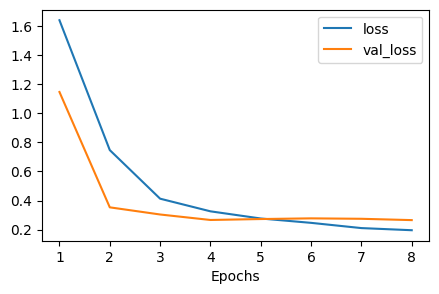

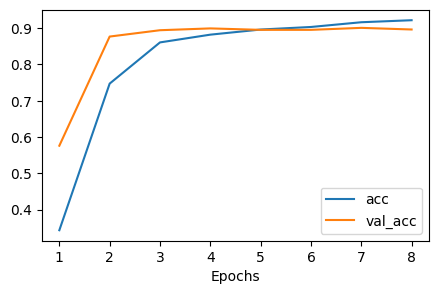

In [11]:
df = DataFrame({'loss': history.history['loss'],
               'val_loss': history.history['val_loss']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'acc': history.history['acc'],
               'val_acc': history.history['val_acc']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

Show the confusion matrix against the test set.

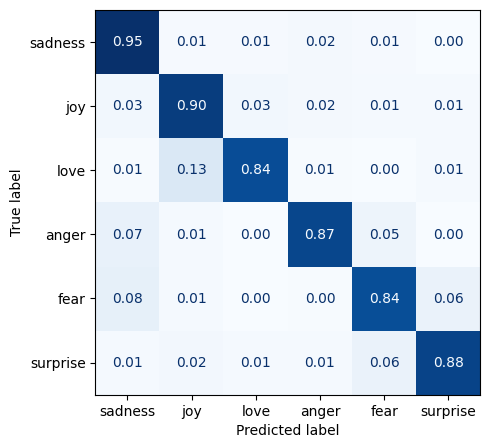

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = transformer_model.predict([test_text, test_mask], verbose=0)

cm = confusion_matrix(
    y_pred = np.argmax(predictions, axis=1),
    y_true = np.argmax(test_label, axis=1),
    normalize='true')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=emotions['validation'].features['label'].names)
_ = disp.plot(cmap='Blues', values_format='.2f', colorbar=False, ax=ax)

Show predictions for some sample texts.

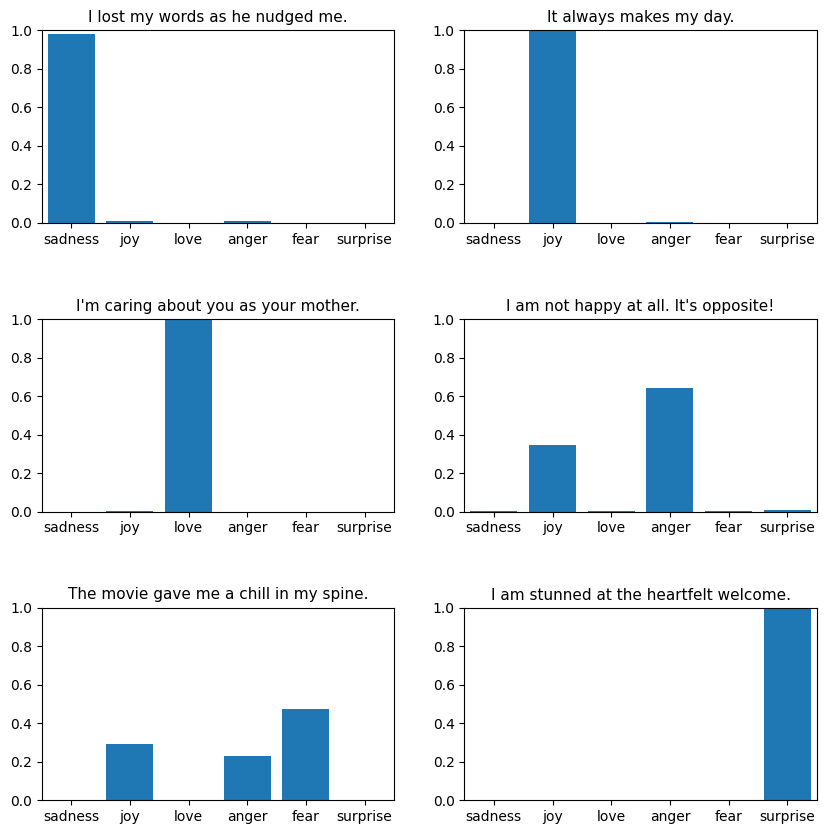

In [69]:
input_text = [
    "I lost my words as he nudged me.",
    "It always makes my day.",
    "I'm caring about you as your mother.",
    "I am not happy at all. It's opposite!",
    "The movie gave me a chill in my spine.",
    "I am stunned at the heartfelt welcome."]

tokenized_text = tokenizer(input_text, max_length=MAX_LEN,
                           padding='max_length', truncation=True)
input_ids = np.array(tokenized_text['input_ids'])
mask = np.array(tokenized_text['attention_mask'])

predictions = transformer_model.predict([input_ids, mask], verbose=0)

n = len(predictions)
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)

for c, pred in enumerate(predictions):
    subplot = fig.add_subplot(3, 2, c+1)
    subplot.set_xticks(range(6))
    subplot.set_xlim([-0.5, 5.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(emotion_labels)
    subplot.set_title(input_text[c], fontsize=11)
    _ = subplot.bar(range(6), pred, align='center')

Show attention weights (averaged over multiple attention heads) for two Transformer encoder layers.

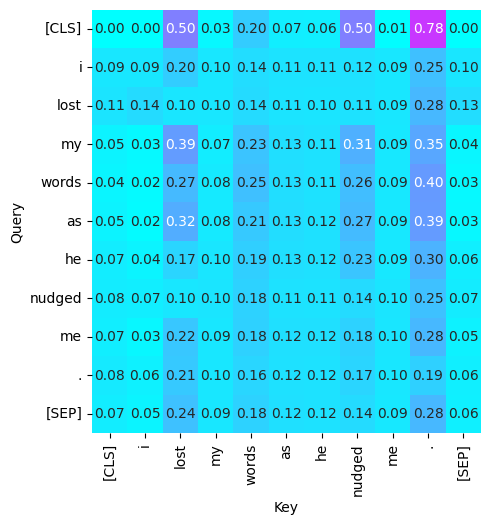

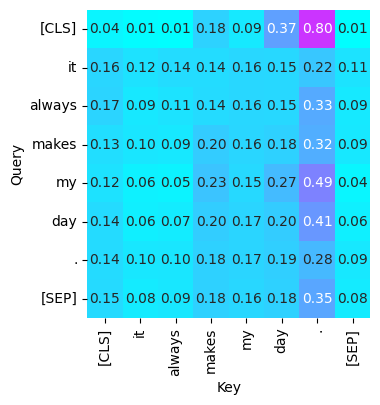

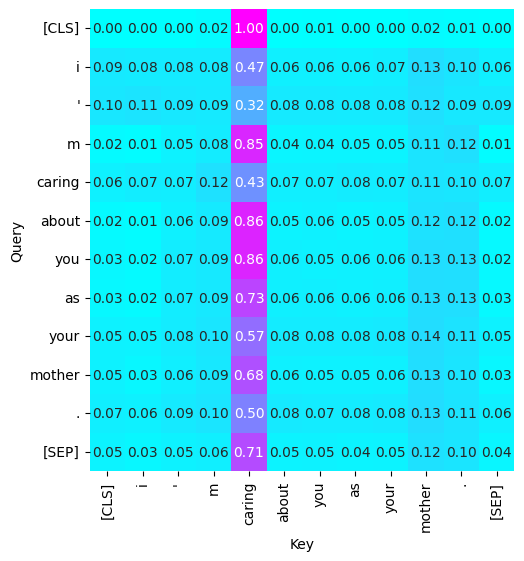

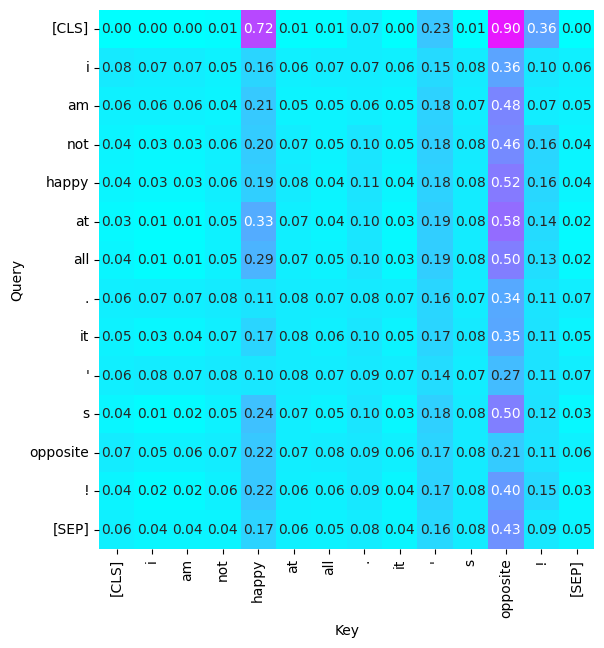

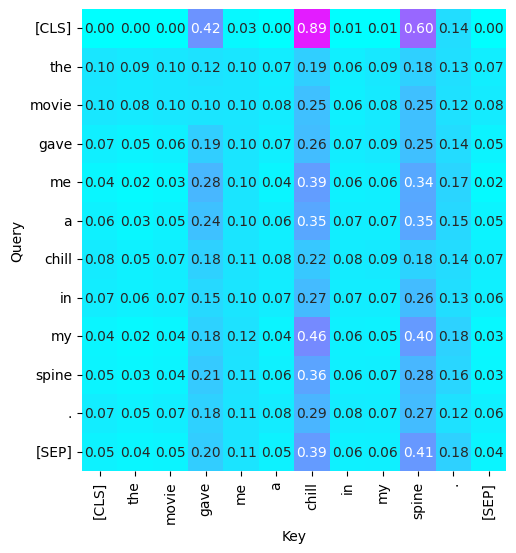

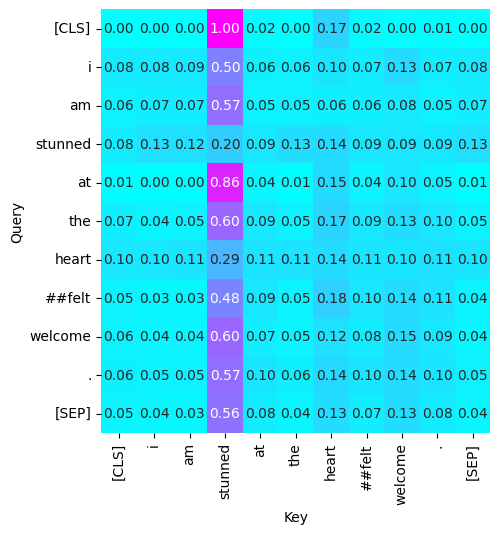

In [75]:
import seaborn as sns

pred, attention_scores1, attention_scores2 = attention_scores_model.predict(
    [input_ids, mask], verbose=0)

for c, text in enumerate(input_text):
    labels = tokenizer.convert_ids_to_tokens(input_ids[c])
    text_len = sum(mask[c])
    fig = plt.figure(figsize=(text_len*1.05, text_len/2))
    fig.subplots_adjust(hspace=0, wspace=0.3)
    subplot = fig.add_subplot(1, 2, 1)
    scores1, scores2 = attention_scores1[c], attention_scores2[c]
    scores1_max = np.max(scores1[:, :text_len, :text_len], axis=0)
    scores2_max = np.max(scores2[:, :text_len, :text_len], axis=0)
    scores = (scores1_max + scores2_max) / 2
    heatmap = sns.heatmap(
        scores, ax = subplot, cmap='cool', vmin=0, vmax=1, cbar=False,
        annot=True, fmt='1.2f')
    heatmap.set_xticklabels(labels[:text_len], rotation = 90)
    heatmap.set_yticklabels(labels[:text_len], rotation = 0)
    _ = heatmap.set(xlabel='Key', ylabel='Query')